In [35]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import time

In [2]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


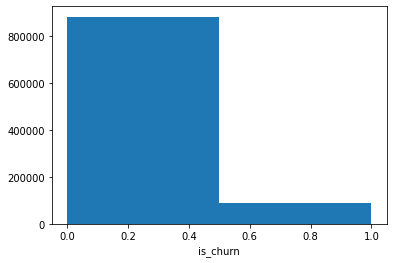

In [3]:
# Importing the data from the csv files (File path may be varied accordingly)
train_df=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem2/Churn Prediction/train_v2.csv')
transaction_df=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem2/Churn Prediction/transactions_v2.csv')
members_df=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem2/Churn Prediction/members_v3.csv')
userlogs_df=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem2/Churn Prediction/user_logs_v2.csv')

plt.hist(train_df['is_churn'], bins = [0,0.5,1])
plt.xlabel('is_churn')
plt.show()

Here, we can clearly observe that the data is very irregularly distributed among the two labels for the target variable, thus we are required to boost the data to make effective predictions based on it.<br>
As the size of the data is very large here and that Google Colab would not provide sufficient RAM for the computation, we would go for random down sampling of the data.

In [4]:
# Random sampling of the train_df data for each of the labels for target variable
train_df_0=train_df.loc[train_df['is_churn'] == 0].sample(n=2000)
train_df_1=train_df.loc[train_df['is_churn'] == 1].sample(n=2000)
train_df = pd.concat([train_df_0, train_df_1])

In [5]:
# Merging all the different datasets to obtain a combined dataset
data = pd.merge(train_df, transaction_df, on='msno', how='left')
data = pd.merge(data, members_df, on='msno', how='left')
data = pd.merge(data, userlogs_df, on='msno', how='left')
display(data)

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,Iv5eYXSA9jgg6nPYIO+Xm22UuKHqmuz8+Kv84dHTXTc=,0,41.0,30.0,99.0,99.0,1.0,20170319.0,20170419.0,0.0,1.0,0.0,NaN,7.0,20151019.0,20170325.0,46.0,4.0,2.0,2.0,31.0,65.0,9136.960
1,Iv5eYXSA9jgg6nPYIO+Xm22UuKHqmuz8+Kv84dHTXTc=,0,41.0,30.0,99.0,99.0,1.0,20170319.0,20170419.0,0.0,1.0,0.0,NaN,7.0,20151019.0,20170330.0,3.0,0.0,2.0,0.0,24.0,27.0,6380.862
2,Iv5eYXSA9jgg6nPYIO+Xm22UuKHqmuz8+Kv84dHTXTc=,0,41.0,30.0,99.0,99.0,1.0,20170319.0,20170419.0,0.0,1.0,0.0,NaN,7.0,20151019.0,20170306.0,8.0,2.0,2.0,0.0,3.0,14.0,1210.647
3,GQTa8OFfXewCIusWVP3ba/257fM/CatzuqrPB/Kra7I=,0,41.0,30.0,149.0,149.0,1.0,20170310.0,20170410.0,0.0,1.0,0.0,NaN,7.0,20140211.0,20170323.0,3.0,3.0,0.0,0.0,13.0,19.0,3706.064
4,GQTa8OFfXewCIusWVP3ba/257fM/CatzuqrPB/Kra7I=,0,41.0,30.0,149.0,149.0,1.0,20170310.0,20170410.0,0.0,1.0,0.0,NaN,7.0,20140211.0,20170313.0,5.0,3.0,3.0,3.0,9.0,20.0,3700.214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72660,nbQgrBv/0wlUp7hQ6L2fA/Hg+EPTI8lMq87/imixEuY=,1,40.0,30.0,149.0,149.0,1.0,20161220.0,20170403.0,0.0,13.0,0.0,NaN,9.0,20110110.0,20170313.0,0.0,1.0,0.0,1.0,3.0,5.0,1045.318
72661,nbQgrBv/0wlUp7hQ6L2fA/Hg+EPTI8lMq87/imixEuY=,1,40.0,30.0,149.0,149.0,1.0,20161220.0,20170403.0,0.0,13.0,0.0,NaN,9.0,20110110.0,20170314.0,4.0,0.0,3.0,2.0,14.0,21.0,4680.012
72662,nbQgrBv/0wlUp7hQ6L2fA/Hg+EPTI8lMq87/imixEuY=,1,40.0,30.0,149.0,149.0,1.0,20161220.0,20170403.0,0.0,13.0,0.0,NaN,9.0,20110110.0,20170309.0,2.0,0.0,2.0,0.0,27.0,24.0,7190.164
72663,nbQgrBv/0wlUp7hQ6L2fA/Hg+EPTI8lMq87/imixEuY=,1,40.0,30.0,149.0,149.0,1.0,20161220.0,20170403.0,0.0,13.0,0.0,NaN,9.0,20110110.0,20170311.0,23.0,2.0,3.0,3.0,26.0,28.0,8107.843


In order to take all the information into consideration, we merged the datasets as above. And now, as a result of the random downsampling we did, we can see that the labels for the data are very well distributed across the two labels.

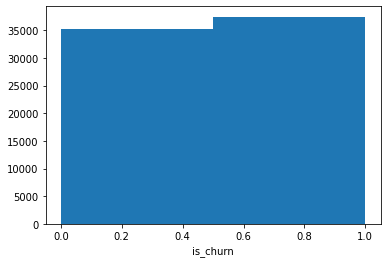

In [6]:
# Studying the variation of the labels now
plt.hist(data['is_churn'], bins = [0,0.5,1])
plt.xlabel('is_churn')
plt.show()

In [7]:
# Overview Analysis of data
for col in data.columns.values:
  list_val=pd.unique(data[col])
  print("--> "+col+" is of type "+str(data[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(data[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(data[col].value_counts())

--> msno is of type object, has 4000 unique values and 0 null entries
--> is_churn is of type int64, has 2 unique values and 0 null entries
    These are: 0, 1
1    37433
0    35232
Name: is_churn, dtype: int64
--> payment_method_id is of type float64, has 32 unique values and 5166 null entries
--> payment_plan_days is of type float64, has 21 unique values and 5166 null entries
--> plan_list_price is of type float64, has 27 unique values and 5166 null entries
--> actual_amount_paid is of type float64, has 27 unique values and 5166 null entries
--> is_auto_renew is of type float64, has 3 unique values and 5166 null entries
    These are: 1.0, 0.0, nan
1.0    48403
0.0    19096
Name: is_auto_renew, dtype: int64
--> transaction_date is of type float64, has 392 unique values and 5166 null entries
--> membership_expire_date is of type float64, has 484 unique values and 5166 null entries
--> is_cancel is of type float64, has 3 unique values and 5166 null entries
    These are: 0.0, nan, 1.0


#### Data Pre-processing

In [8]:
# A function that takes care of all the null values and unwanted columns in the dataset
# Returns two seperate dataframes X (feature vectors) and Y (labels)
def process(data):
  # Substituting 0 for blank payment_method_id
  data['payment_method_id'] = data['payment_method_id'].fillna(0)

  # Removing outliers
  data['payment_plan_days'] = data['payment_plan_days'].apply(lambda x: x if (x <= 30.0) else np.nan)
  # Set the default payment_plan_days to 30 days
  data['payment_plan_days'] = data['payment_plan_days'].fillna(30.0)

  # Removing outliers
  data['plan_list_price'] = data['plan_list_price'].apply(lambda x: x if (x <= 180.0) else np.nan)
  # Set the default plan_list_price to 149
  data['plan_list_price'] = data['plan_list_price'].fillna(149.0)

  # Removing outliers
  data['actual_amount_paid'] = data['actual_amount_paid'].apply(lambda x: x if (x <= 180.0) else np.nan)
  # imputing the default actual_amount_paid to 149.0
  data['actual_amount_paid'] = data['actual_amount_paid'].fillna(149.0)

  # Set the default is_auto_renew to 2
  data['is_auto_renew'] = data['is_auto_renew'].fillna(2)

  # Set the default for is_cancel to 2
  data['is_cancel'] = data['is_cancel'].fillna(2)

  # Set the default for city to 0
  data['city'] = data['city'].fillna(0)

  # Eliminating the outliers and considering only age 0-70
  data['bd'] = data['bd'].apply(lambda x: x if (x < 70.0) and (x > 0.0) else np.nan)
  data['bd'] = data['bd'].fillna(28.0)

  # Processing the genders as 0:NaN, 1:Male, 2:Female
  data['gender'] = data['gender'].fillna(0)
  data['gender'] = data['gender'].replace(to_replace='male', value=1)
  data['gender'] = data['gender'].replace(to_replace='female', value=2)

  # Setting median date in place of nan in the df
  data['registration_init_time'] = data['registration_init_time'].fillna(20150204.0)
  # Getting registration_init_time array and store to registration_time list
  registration_time = data['registration_init_time'].values

  # Set the default for registered_via to 0
  data['registered_via'] = data['registered_via'].fillna(0)

  # Removing outliers
  data['num_25'] = data['num_25'].apply(lambda x: x if (x <= 15.0) else np.nan)
  # Set the default num_25 to 2
  data['num_25'] = data['num_25'].fillna(2.0)

  # Removing outliers
  data['num_50'] = data['num_50'].apply(lambda x: x if (x <= 4.0) else np.nan)
  # Set the default num_50 to 0
  data['num_50'] = data['num_50'].fillna(0)

  # Removing outliers
  data['num_75'] = data['num_75'].apply(lambda x: x if (x <= 3.0) else np.nan)
  # Set the default num_75 to 0
  data['num_75'] = data['num_75'].fillna(0)

  # Removing outliers
  data['num_985'] = data['num_985'].apply(lambda x: x if (x <= 3.0) else np.nan)
  # Set the default num_985 to 0
  data['num_985'] = data['num_985'].fillna(0)

  # Removing outliers
  data['num_100'] = data['num_100'].apply(lambda x: x if (x <= 74.0) else np.nan)
  # Set the default num_100 to 14
  data['num_100'] = data['num_100'].fillna(14.0)

  # Removing outliers
  data['num_unq'] = data['num_unq'].apply(lambda x: x if (x <= 68.0) else np.nan)
  # Set the default num_unq to 16
  data['num_unq'] = data['num_unq'].fillna(16.0)

  # Removing outliers
  data['total_secs'] = data['total_secs'].apply(lambda x: x if (x <= 18000) else np.nan)
  # Set the default total_secs to 2
  data['total_secs'] = data['total_secs'].fillna(3900)

  X = data
  X = X.drop(['is_churn', 'msno', 'transaction_date', 'membership_expire_date', 'date'], axis=1)
  Y = data['is_churn']

  return X, Y

In [9]:
X, Y = process(data)
display(X)

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,bd,gender,registered_via,registration_init_time,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,41.0,30.0,99.0,99.0,1.0,0.0,1.0,28.0,0,7.0,20151019.0,2.0,4.0,2.0,2.0,31.0,65.0,9136.960
1,41.0,30.0,99.0,99.0,1.0,0.0,1.0,28.0,0,7.0,20151019.0,3.0,0.0,2.0,0.0,24.0,27.0,6380.862
2,41.0,30.0,99.0,99.0,1.0,0.0,1.0,28.0,0,7.0,20151019.0,8.0,2.0,2.0,0.0,3.0,14.0,1210.647
3,41.0,30.0,149.0,149.0,1.0,0.0,1.0,28.0,0,7.0,20140211.0,3.0,3.0,0.0,0.0,13.0,19.0,3706.064
4,41.0,30.0,149.0,149.0,1.0,0.0,1.0,28.0,0,7.0,20140211.0,5.0,3.0,3.0,3.0,9.0,20.0,3700.214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72660,40.0,30.0,149.0,149.0,1.0,0.0,13.0,28.0,0,9.0,20110110.0,0.0,1.0,0.0,1.0,3.0,5.0,1045.318
72661,40.0,30.0,149.0,149.0,1.0,0.0,13.0,28.0,0,9.0,20110110.0,4.0,0.0,3.0,2.0,14.0,21.0,4680.012
72662,40.0,30.0,149.0,149.0,1.0,0.0,13.0,28.0,0,9.0,20110110.0,2.0,0.0,2.0,0.0,27.0,24.0,7190.164
72663,40.0,30.0,149.0,149.0,1.0,0.0,13.0,28.0,0,9.0,20110110.0,2.0,2.0,3.0,3.0,26.0,28.0,8107.843


#### Principal Component Analysis

In [10]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X.to_numpy())

print("Variance retained: %s" % (sum(pca.explained_variance_ratio_)))

Variance retained: 0.9999999861118716


We reduce the dimensionality of the feature vectors from 18 to 10 to reduce the irrelevant information, and yet we can see that we 99.99999% of the variance is still retained thus depicting very minute fraction of information being lost.

#### Pre-processing the data for ML model

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, Y, test_size=0.4, random_state=57)
display(X_train)

array([[-2.01651453e+04, -2.37572706e+03, -2.34271982e+01, ...,
        -7.34496010e+00, -2.57107581e-01,  6.77711104e+00],
       [-3.06584265e+04,  2.07655308e+02, -2.69057121e+01, ...,
         1.51166470e+00, -1.21037936e+01, -2.70010638e+00],
       [ 1.97393817e+04,  4.96437511e+03, -1.01358194e+01, ...,
        -8.08486496e+00,  4.74143561e+00, -1.69712055e+00],
       ...,
       [ 8.84305257e+03, -6.58112142e+02, -1.40552754e+01, ...,
        -3.48681427e+00,  4.03362540e+00, -5.15377431e-01],
       [-3.01568363e+04, -5.50362175e+02,  4.47074608e+01, ...,
         3.53848266e+00,  9.50585748e-02, -2.84535375e+00],
       [-2.03381857e+04,  6.32693234e+03, -2.22962715e+01, ...,
         2.09854199e+00,  2.05856789e-01, -3.45549500e+00]])

In [12]:
scaler= preprocessing.StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train))
display(X_train)
X_val=pd.DataFrame(scaler.transform(X_val))

,0,1,2,3,4,5,6,7,8,9
0,-0.687664,-0.590050,-0.520234,-0.242445,-0.324451,0.162295,-1.021035,-1.147345,-0.048005,2.028244
1,-1.042317,0.053301,-0.597228,-1.285292,1.572849,-0.628002,-0.107704,0.240350,-2.073917,-0.807547
2,0.661033,1.237889,-0.226041,-0.722524,-0.450755,0.202295,-0.291774,-1.263277,0.806801,-0.507432
3,1.667763,-0.993442,-0.032307,0.324517,-0.519717,0.111403,-0.025866,2.242327,2.631106,0.304023
4,0.292652,-0.585067,-0.316785,0.356768,-0.320187,0.094912,0.009505,-0.546912,0.685170,-0.675049
...,...,...,...,...,...,...,...,...,...,...
43594,-0.038997,-0.263572,1.182813,0.095485,-0.435546,-0.085025,-0.132062,-0.973948,0.338421,-0.857990
43595,-0.714371,-0.072486,-0.509172,0.417774,-0.713761,0.220464,-0.142396,0.805724,-0.335950,-0.515628
43596,0.292757,-0.162305,-0.312795,0.312292,-0.312621,0.091112,-0.167330,-0.542834,0.685757,-0.153829
43597,-1.025364,-0.135471,0.987866,0.134672,-0.608814,-0.040880,0.082868,0.557921,0.012219,-0.851009


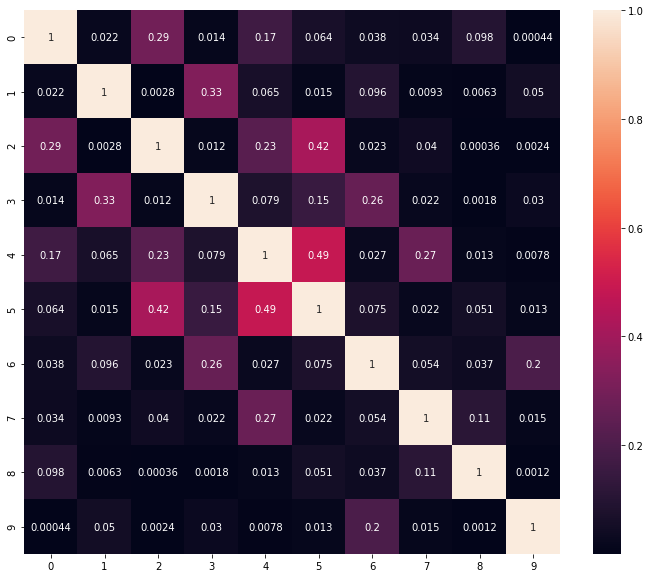

In [15]:
corrMatrix = X_train.corr(method='spearman')
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(abs(corrMatrix), annot=True)
plt.show()

The correlation matrix here does show that all the features are very much independent of each other.

#### Building an ML model: Random Forest Classifier

Having trained the model on several classifiers including Logistic regression, Support Vector Classifiers, etc., it was found out that the data performed the best on Random Forest Classifier as shown below achieving an ROC-AUC score of more than 96 percent.

In [37]:
start_time=time.time()
scoring = 'f1'
rfc = RandomForestClassifier()
hyperparameters = {'max_depth':[2,5,10,20],'n_estimators':[10,30,100]}
clf = GridSearchCV(rfc, param_grid=hyperparameters, scoring='f1')
clf.fit(np.array(X_train), np.squeeze(y_train))
print('Training time for Random Forest Classifier: %.2f seconds \n'%(time.time()-start_time))
print('Best parameters: ')
print(clf.best_params_)
print('Best' +scoring+":" +str(clf.best_score_))

print('Test classification report:')
y_true, y_pred = np.squeeze(y_val), clf.predict(np.array(X_val))
print(classification_report(y_true, y_pred))

print('Test AUC-ROC: '+str(roc_auc_score(y_true, y_pred)))

Training time for Random Forest Classifier: 236.18 seconds 

Best parameters: 
{'max_depth': 20, 'n_estimators': 100}
Bestf1:0.9586959444391026
Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     14080
           1       0.97      0.96      0.96     14986

    accuracy                           0.96     29066
   macro avg       0.96      0.96      0.96     29066
weighted avg       0.96      0.96      0.96     29066

Test AUC-ROC: 0.9644002394659258


#### Model evaluation

In order to further evaluate the model, we test it on a completely unseen test data.

In [31]:
test_df=train_df.sample(n=2000)

In [32]:
test = pd.merge(test_df, transaction_df, on='msno', how='left')
test = pd.merge(test, members_df, on='msno', how='left')
test = pd.merge(test, userlogs_df, on='msno', how='left')
display(test)

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,city,bd,gender,registered_via,registration_init_time,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,kCjPafvqETvh8MwdNizM51SugUUFK4mqJ0qw/jAPI60=,0,41.0,30.0,149.0,149.0,1.0,20170312.0,20170412.0,0.0,1.0,0.0,NaN,7.0,20150705.0,20170328.0,8.0,4.0,0.0,0.0,19.0,15.0,5258.711
1,kCjPafvqETvh8MwdNizM51SugUUFK4mqJ0qw/jAPI60=,0,41.0,30.0,149.0,149.0,1.0,20170312.0,20170412.0,0.0,1.0,0.0,NaN,7.0,20150705.0,20170326.0,1.0,1.0,1.0,0.0,10.0,12.0,2719.028
2,kCjPafvqETvh8MwdNizM51SugUUFK4mqJ0qw/jAPI60=,0,41.0,30.0,149.0,149.0,1.0,20170312.0,20170412.0,0.0,1.0,0.0,NaN,7.0,20150705.0,20170314.0,2.0,0.0,0.0,1.0,4.0,5.0,1325.165
3,kCjPafvqETvh8MwdNizM51SugUUFK4mqJ0qw/jAPI60=,0,41.0,30.0,149.0,149.0,1.0,20170312.0,20170412.0,0.0,1.0,0.0,NaN,7.0,20150705.0,20170308.0,1.0,0.0,1.0,1.0,5.0,7.0,1618.265
4,kCjPafvqETvh8MwdNizM51SugUUFK4mqJ0qw/jAPI60=,0,41.0,30.0,149.0,149.0,1.0,20170312.0,20170412.0,0.0,1.0,0.0,NaN,7.0,20150705.0,20170311.0,2.0,2.0,0.0,0.0,12.0,16.0,3424.899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36104,cSl0P5nP7DP0GkZ9bsal9i9gntPvAJQQoFuWxVvHpnI=,1,40.0,30.0,149.0,149.0,1.0,20170302.0,20170404.0,0.0,8.0,20.0,female,9.0,20110205.0,20170317.0,1.0,0.0,0.0,1.0,22.0,23.0,5508.875
36105,cSl0P5nP7DP0GkZ9bsal9i9gntPvAJQQoFuWxVvHpnI=,1,40.0,30.0,149.0,149.0,1.0,20170302.0,20170404.0,0.0,8.0,20.0,female,9.0,20110205.0,20170313.0,0.0,0.0,0.0,0.0,5.0,5.0,1291.933
36106,cSl0P5nP7DP0GkZ9bsal9i9gntPvAJQQoFuWxVvHpnI=,1,40.0,30.0,149.0,149.0,1.0,20170302.0,20170404.0,0.0,8.0,20.0,female,9.0,20110205.0,20170328.0,2.0,0.0,1.0,0.0,13.0,14.0,3526.201
36107,cSl0P5nP7DP0GkZ9bsal9i9gntPvAJQQoFuWxVvHpnI=,1,40.0,30.0,149.0,149.0,1.0,20170302.0,20170404.0,0.0,8.0,20.0,female,9.0,20110205.0,20170321.0,0.0,1.0,2.0,0.0,17.0,18.0,4452.707


In [33]:
# Processing the data to take care of null values and unwanted columns
X_test, y_test = process(test)

# PCA Fitting
X_test_pca = pca.fit_transform(X_test.to_numpy())

# Standardising the X_test data
X_test=pd.DataFrame(scaler.transform(X_test_pca))

In [38]:
start_time = time.time()
y_true, y_pred = np.squeeze(y_test), clf.predict(np.array(X_test))
print('Testing time: %.2f seconds \n'%(time.time()-start_time))

print('Test classification report:')
print(classification_report(y_true, y_pred))

print('Test AUC-ROC: '+str(roc_auc_score(y_true, y_pred)))

Testing time: 0.50 seconds 

Test classification report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.81     17776
           1       0.83      0.76      0.79     18333

    accuracy                           0.80     36109
   macro avg       0.80      0.80      0.80     36109
weighted avg       0.80      0.80      0.80     36109

Test AUC-ROC: 0.8000961761615534


And here we can see that the model makes predictions with an accuracy of 80% on this test dataset.

#### Further Scope For Improvements

1. The down-sampling of the training data leads to loss of information as we consider only a subset of the data points available to us. Instead, with high computational powers, we can use data boosting techniques like AdaBoost, XGBoost, etc.
2. The models being trained so far were simple Machine Learning models, be it SVM or Logistic Regression or Random Forest Classifiers. To further improve the accuracy of prediction, we can use Deep Learning models like Tensorflow, CNNs, etc